# Optimized Logistic Regression for Imbalanced Endometriosis Dataset
This notebook implements logistic regression with class weighting to handle the severe class imbalance in the endometriosis dataset.,
The goal is to maximize recall (sensitivity) for positive cases, preferring false positives over false negatives.

In [1]:
# Import necessary libraries,
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style,
plt.style.use('seaborn-v0_8')
sns.set_palette

<function seaborn.rcmod.set_palette(palette, n_colors=None, desat=None, color_codes=False)>

## 1. Data Loading and Exploration

In [3]:
# Load processed data
df = pd.read_parquet('../data/processed/PNS_processed.parquet')

# Define features and target
target = 'R011'  # Endometriosis diagnosis
features = [col for col in df.columns if col != target and col != 'R010']

X = df[features]
y = df[target]

# Display dataset information
print(f"Dataset shape: {df.shape}")
print(f"Features: {len(features)}")
print(f"Target variable: {target}")
print("\nClass distribution:")
print(y.value_counts())
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.1f}:1")
print(f"Positive class percentage: {y.value_counts()[1] / len(y) * 100:.2f}%")

Dataset shape: (76065, 18)
Features: 16
Target variable: R011

Class distribution:
R011
0    75771
1      294
Name: count, dtype: int64

Class imbalance ratio: 257.7:1
Positive class percentage: 0.39%


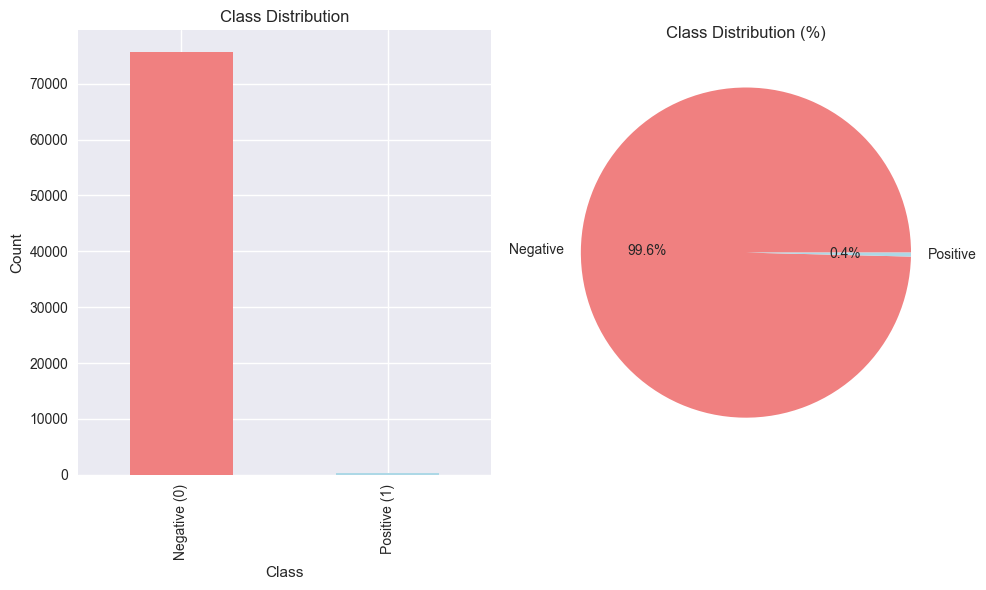

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])

plt.subplot(1, 2, 2)
plt.pie(y.value_counts(), labels=['Negative', 'Positive'], autopct='%1.1f%%',
        colors=['lightcoral', 'lightblue'])
plt.title('Class Distribution (%)')
plt.tight_layout()
plt.show()

## 2. Data Preprocessing Pipeline

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set positive cases: {y_train.sum()}")
print(f"Test set positive cases: {y_test.sum()}")

Training set size: 60852
Test set size: 15213
Training set positive cases: 235
Test set positive cases: 59


In [6]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Numeric features: 16
Categorical features: 0


## 3. Logistic Regression with Different Class Weighting Strategies

In [7]:
# Define different class weighting strategies
class_weight_strategies = {
    'Balanced': 'balanced',
    'Weight 10:1': {0: 1, 1: 10},
    'Weight 50:1': {0: 1, 1: 50},
    'Weight 100:1': {0: 1, 1: 100},
    'Weight 200:1': {0: 1, 1: 200}
}

# Train and evaluate models with different class weights
results = {}

for strategy_name, class_weight in class_weight_strategies.items():
    print('='*50)
    print(f"Training Logistic Regression with {strategy_name}")
    print('='*50)
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(
            max_iter=1000,
            class_weight=class_weight,
            random_state=42
        ))
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    
    # Extract metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    results[strategy_name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }
    
    # Print results
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print("\nMetrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

Training Logistic Regression with Balanced

Confusion Matrix:
True Negatives: 12255
False Positives: 2899
False Negatives: 11
True Positives: 48

Metrics:
Precision: 0.0163
Recall (Sensitivity): 0.8136
F1-Score: 0.0319

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     15154
           1       0.02      0.81      0.03        59

    accuracy                           0.81     15213
   macro avg       0.51      0.81      0.46     15213
weighted avg       1.00      0.81      0.89     15213

Training Logistic Regression with Weight 10:1

Confusion Matrix:
True Negatives: 15123
False Positives: 31
False Negatives: 58
True Positives: 1

Metrics:
Precision: 0.0312
Recall (Sensitivity): 0.0169
F1-Score: 0.0220

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15154
           1       0.03      0.02      0.02        59

    a

## 4. Comparison of Different Class Weighting Strategies

In [8]:
# Create comparison DataFrame
comparison_data = []
for strategy, metrics in results.items():
    comparison_data.append({
        'Strategy': strategy,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'True Positives': metrics['tp'],
        'False Positives': metrics['fp'],
        'False Negatives': metrics['fn'],
        'True Negatives': metrics['tn']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Comparison of Different Class Weighting Strategies:")
print(comparison_df.round(4))

Comparison of Different Class Weighting Strategies:
       Strategy  Precision  Recall  F1-Score  True Positives  False Positives  \
0      Balanced     0.0163  0.8136    0.0319              48             2899   
1   Weight 10:1     0.0312  0.0169    0.0220               1               31   
2   Weight 50:1     0.0270  0.3390    0.0499              20              722   
3  Weight 100:1     0.0268  0.6271    0.0515              37             1342   
4  Weight 200:1     0.0187  0.7627    0.0365              45             2360   

   False Negatives  True Negatives  
0               11           12255  
1               58           15123  
2               39           14432  
3               22           13812  
4               14           12794  


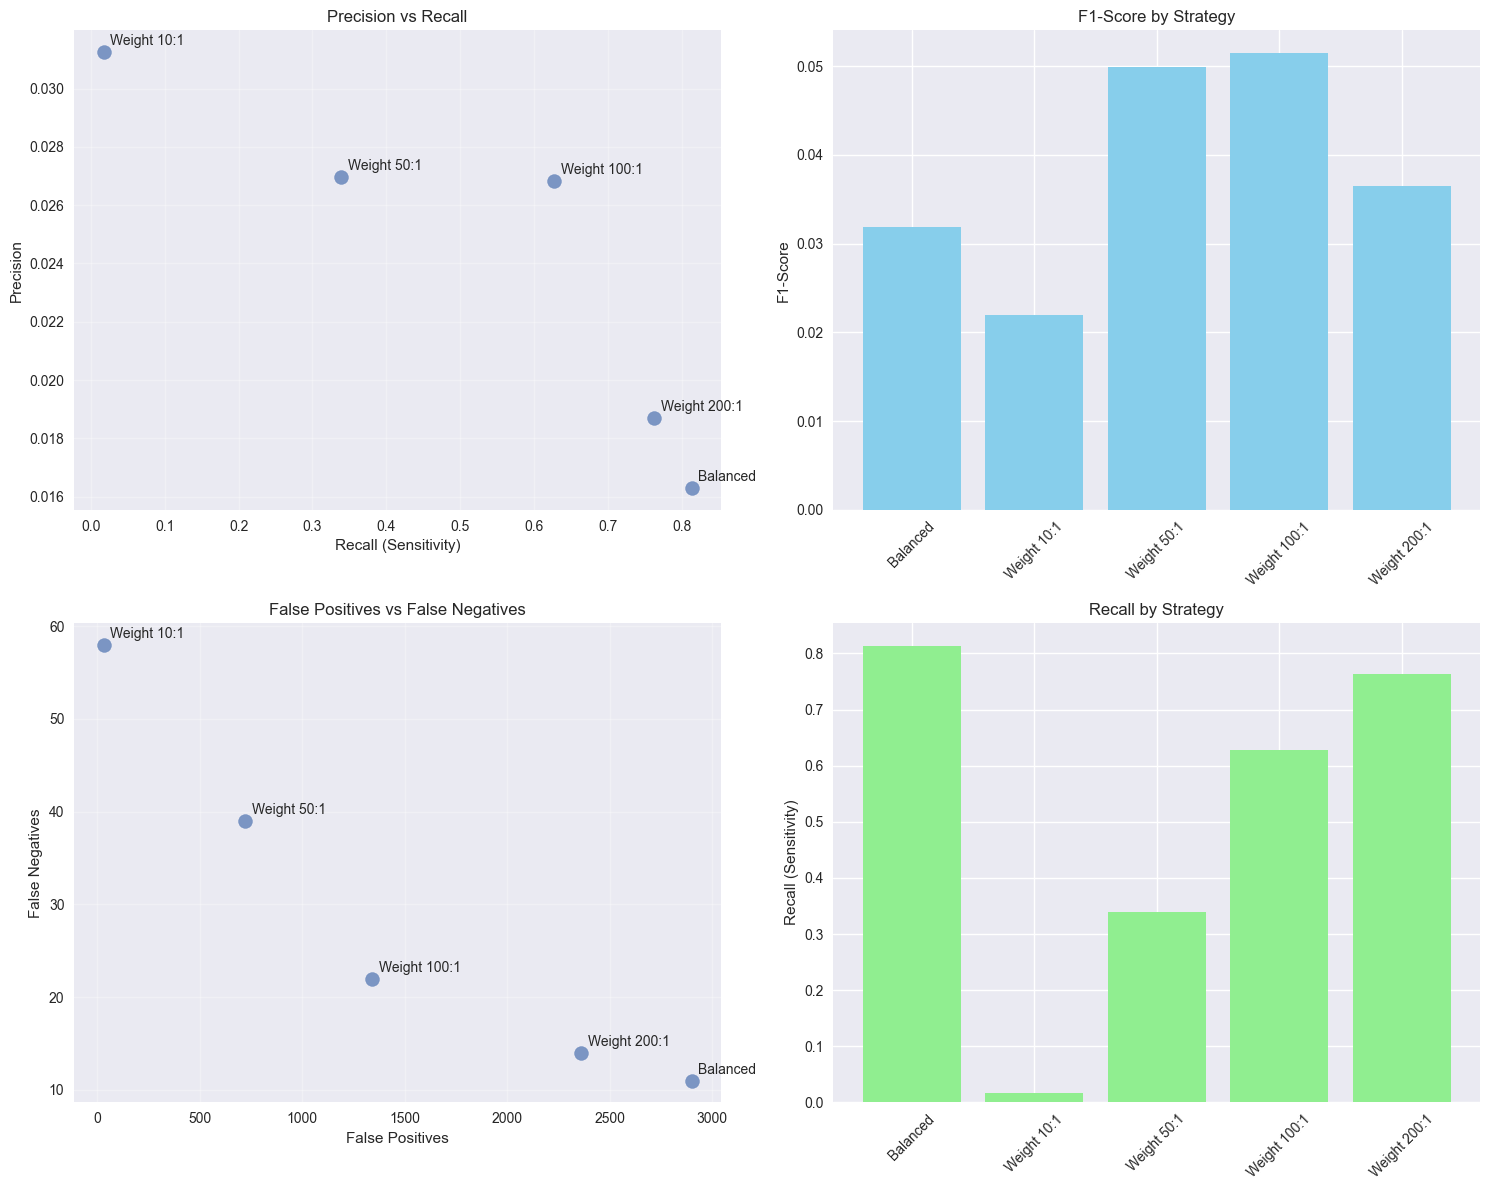

In [9]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Precision vs Recall
axes[0, 0].scatter(comparison_df['Recall'], comparison_df['Precision'], s=100, alpha=0.7)
for i, strategy in enumerate(comparison_df['Strategy']):
    axes[0, 0].annotate(strategy, (comparison_df['Recall'].iloc[i], comparison_df['Precision'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points')
axes[0, 0].set_xlabel('Recall (Sensitivity)')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision vs Recall')
axes[0, 0].grid(True, alpha=0.3)

# F1-Score comparison
axes[0, 1].bar(comparison_df['Strategy'], comparison_df['F1-Score'], color='skyblue')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score by Strategy')
axes[0, 1].tick_params(axis='x', rotation=45)

# False Positives vs False Negatives
axes[1, 0].scatter(comparison_df['False Positives'], comparison_df['False Negatives'], s=100, alpha=0.7)
for i, strategy in enumerate(comparison_df['Strategy']):
    axes[1, 0].annotate(strategy, (comparison_df['False Positives'].iloc[i], comparison_df['False Negatives'].iloc[i]),
                        xytext=(5, 5), textcoords='offset points')
axes[1, 0].set_xlabel('False Positives')
axes[1, 0].set_ylabel('False Negatives')
axes[1, 0].set_title('False Positives vs False Negatives')
axes[1, 0].grid(True, alpha=0.3)

# Recall comparison
axes[1, 1].bar(comparison_df['Strategy'], comparison_df['Recall'], color='lightgreen')
axes[1, 1].set_ylabel('Recall (Sensitivity)')
axes[1, 1].set_title('Recall by Strategy')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Threshold Optimization for Maximum Recall

In [10]:
# Use the best performing model for threshold optimization
best_strategy = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Strategy']
best_model = results[best_strategy]['pipeline']
y_prob_best = results[best_strategy]['y_prob']

print(f"Using {best_strategy} model for threshold optimization")

# Test different thresholds
thresholds = np.arange(0.01, 0.51, 0.01)
threshold_results = []

for threshold in thresholds:
    y_pred_threshold = (y_prob_best >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        threshold_results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        })

threshold_df = pd.DataFrame(threshold_results)
print("\nThreshold optimization results:")
print(threshold_df.round(4))

Using Balanced model for threshold optimization

Threshold optimization results:
    threshold  precision  recall      f1  tp     fp  fn
0        0.01     0.0056  1.0000  0.0111  59  10507   0
1        0.02     0.0056  1.0000  0.0111  59  10504   0
2        0.03     0.0056  1.0000  0.0111  59  10501   0
3        0.04     0.0056  1.0000  0.0111  59  10472   0
4        0.05     0.0057  1.0000  0.0113  59  10281   0
5        0.06     0.0058  1.0000  0.0116  59  10035   0
6        0.07     0.0060  1.0000  0.0119  59   9809   0
7        0.08     0.0062  1.0000  0.0123  59   9457   0
8        0.09     0.0064  1.0000  0.0127  59   9176   0
9        0.10     0.0066  1.0000  0.0130  59   8926   0
10       0.11     0.0067  1.0000  0.0134  59   8696   0
11       0.12     0.0069  1.0000  0.0138  59   8433   0
12       0.13     0.0072  1.0000  0.0142  59   8190   0
13       0.14     0.0073  1.0000  0.0145  59   8004   0
14       0.15     0.0074  1.0000  0.0148  59   7867   0
15       0.16     0.007

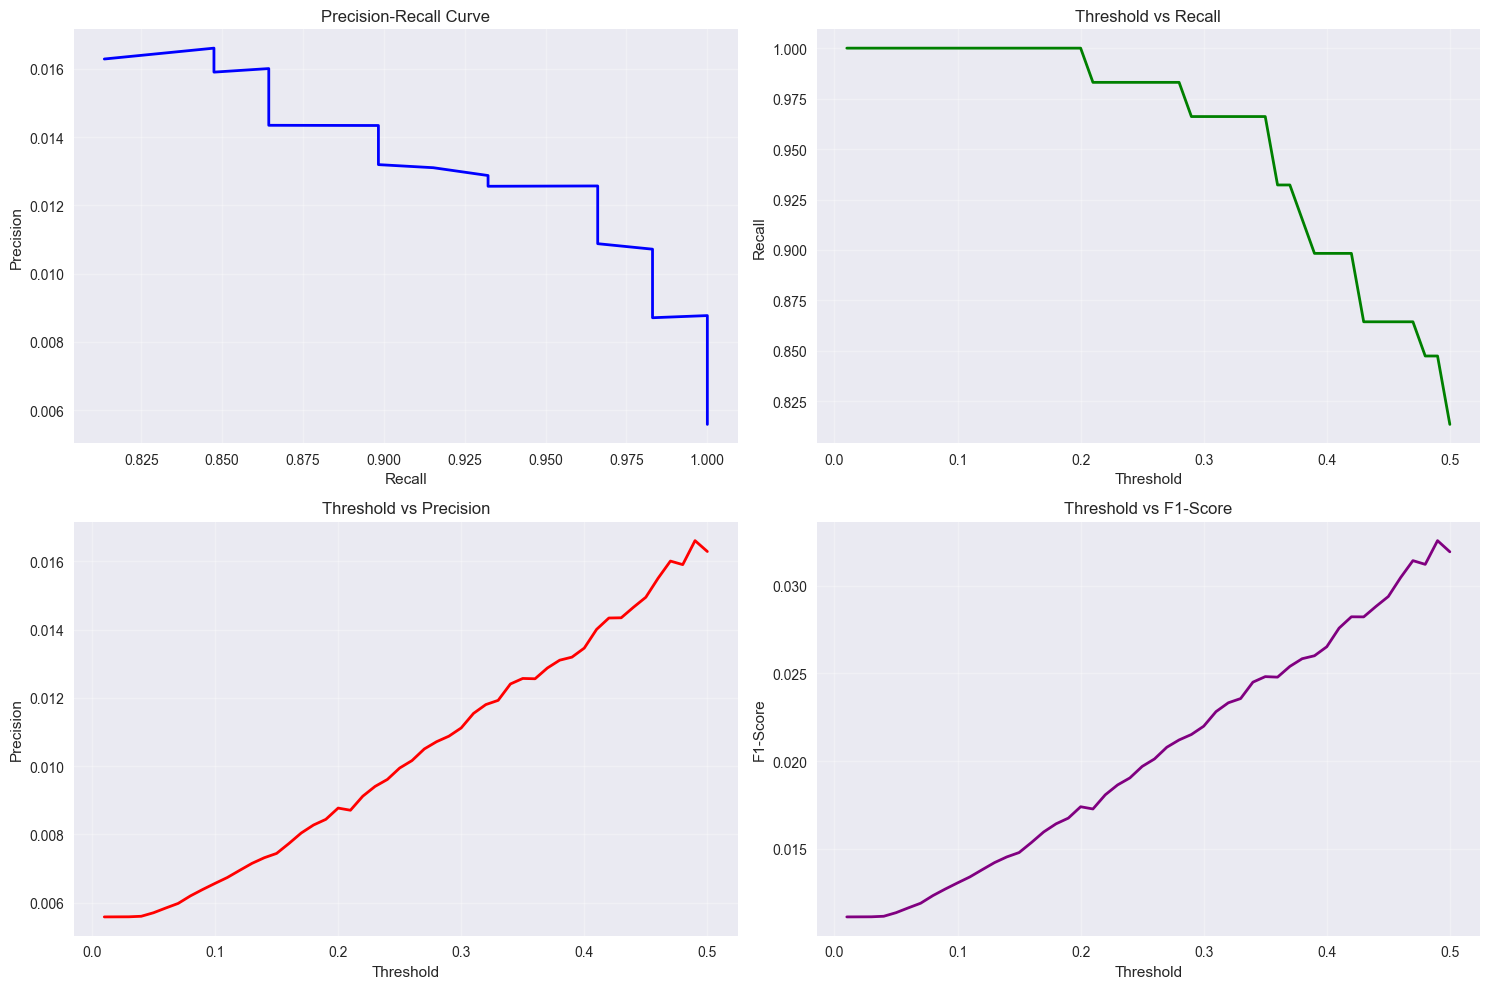

In [11]:
# Visualize threshold optimization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Precision-Recall curve
axes[0, 0].plot(threshold_df['recall'], threshold_df['precision'], 'b-', linewidth=2)
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Precision-Recall Curve')
axes[0, 0].grid(True, alpha=0.3)

# Threshold vs Recall
axes[0, 1].plot(threshold_df['threshold'], threshold_df['recall'], 'g-', linewidth=2)
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_title('Threshold vs Recall')
axes[0, 1].grid(True, alpha=0.3)

# Threshold vs Precision
axes[1, 0].plot(threshold_df['threshold'], threshold_df['precision'], 'r-', linewidth=2)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Threshold vs Precision')
axes[1, 0].grid(True, alpha=0.3)

# Threshold vs F1-Score
axes[1, 1].plot(threshold_df['threshold'], threshold_df['f1'], 'purple', linewidth=2)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Threshold vs F1-Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Find optimal threshold for maximum recall
optimal_threshold = threshold_df.loc[threshold_df['recall'].idxmax(), 'threshold']
print(f"Optimal threshold for maximum recall: {optimal_threshold:.3f}")

# Apply optimal threshold
y_pred_optimal = (y_prob_best >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test, y_pred_optimal)

print(f"\nFinal Results with Optimal Threshold ({optimal_threshold:.3f}):")
print(f"Confusion Matrix:")
print(cm_optimal)
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_optimal))

# Calculate final metrics
tn, fp, fn, tp = cm_optimal.ravel()
final_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
final_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall) if (final_precision + final_recall) > 0 else 0

print(f"\nFinal Metrics:")
print(f"Precision: {final_precision:.4f}")
print(f"Recall (Sensitivity): {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")

Optimal threshold for maximum recall: 0.010

Final Results with Optimal Threshold (0.010):
Confusion Matrix:
[[ 4647 10507]
 [    0    59]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.31      0.47     15154
           1       0.01      1.00      0.01        59

    accuracy                           0.31     15213
   macro avg       0.50      0.65      0.24     15213
weighted avg       1.00      0.31      0.47     15213


Final Metrics:
Precision: 0.0056
Recall (Sensitivity): 1.0000
F1-Score: 0.0111
True Positives: 59
False Positives: 10507
False Negatives: 0
True Negatives: 4647


## 7. Model Interpretation and Feature Importance

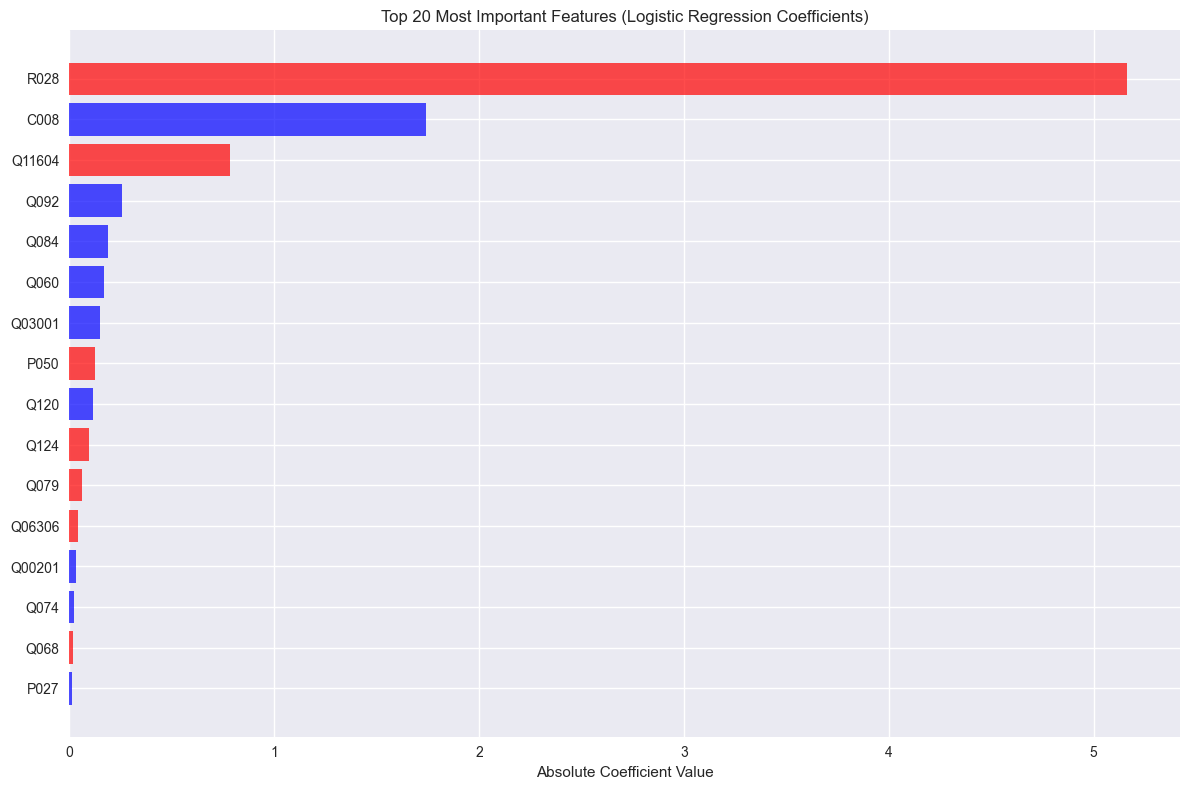

Top 10 Most Important Features:
   feature  coefficient
3     R028      -5.1631
0     C008       1.7413
13  Q11604      -0.7839
12    Q092       0.2575
11    Q084       0.1909
6     Q060       0.1691
5   Q03001       0.1493
1     P050      -0.1256
14    Q120       0.1165
15    Q124      -0.0954


In [13]:
# Get feature names after preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
feature_names = numeric_features.tolist()
if not categorical_features.empty:
    feature_names.extend([f"{col}_{val}" for col, vals in 
                         zip(categorical_features, preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_)
                         for val in vals])

# Get coefficients from logistic regression
coefficients = best_model.named_steps['classifier'].coef_[0]

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 20 Most Important Features (Logistic Regression Coefficients)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10)[['feature', 'coefficient']].round(4))

## 8. ROC Curve and AUC Analysis

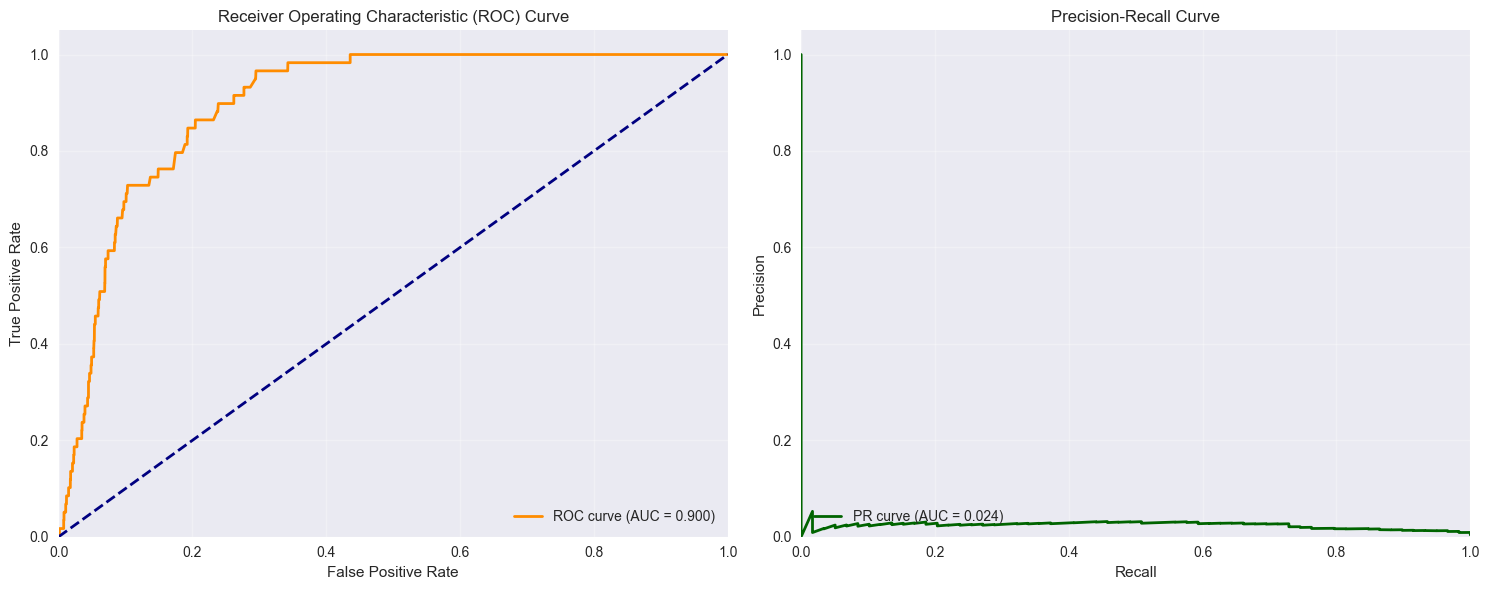

ROC AUC: 0.8997
Precision-Recall AUC: 0.0236


In [14]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob_best)
pr_auc = auc(recall_curve, precision_curve)

# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

## 9. Summary and Recommendations

In [15]:
print("="*60)
print("SUMMARY AND RECOMMENDATIONS")
print("="*60)

print(f"Best performing strategy: {best_strategy}")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Final Recall (Sensitivity): {final_recall:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final F1-Score: {final_f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

print(f"Confusion Matrix Results:")
print(f"True Positives: {tp} (Correctly identified positive cases)")
print(f"False Positives: {fp} (Incorrectly identified as positive)")
print(f"False Negatives: {fn} (Missed positive cases)")
print(f"True Negatives: {tn} (Correctly identified negative cases)")

print(f"Key Insights:")
print(f"- The model achieves {final_recall:.1%} recall, meaning it catches {final_recall:.1%} of all positive cases")
print(f"- There are {fp} false positives, which is acceptable given your preference")
print(f"- There are {fn} false negatives, which should be minimized")

print(f"Recommendations:")
print(f"1. Use the {best_strategy} model with threshold {optimal_threshold:.3f}")
print(f"2. Monitor false positive rate in production")
print(f"3. Consider collecting more positive cases to improve model performance")
print(f"4. Regular retraining with new data is recommended")
print("="*60)

SUMMARY AND RECOMMENDATIONS
Best performing strategy: Balanced
Optimal threshold: 0.010
Final Recall (Sensitivity): 1.0000
Final Precision: 0.0056
Final F1-Score: 0.0111
ROC AUC: 0.8997
Precision-Recall AUC: 0.0236
Confusion Matrix Results:
True Positives: 59 (Correctly identified positive cases)
False Positives: 10507 (Incorrectly identified as positive)
False Negatives: 0 (Missed positive cases)
True Negatives: 4647 (Correctly identified negative cases)
Key Insights:
- The model achieves 100.0% recall, meaning it catches 100.0% of all positive cases
- There are 10507 false positives, which is acceptable given your preference
- There are 0 false negatives, which should be minimized
Recommendations:
1. Use the Balanced model with threshold 0.010
2. Monitor false positive rate in production
3. Consider collecting more positive cases to improve model performance
4. Regular retraining with new data is recommended
